# Packages Imports

In [1]:
import os
import random

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()


import tensorflow as tf
import tensorflow_datasets as tfds

from keras.utils import to_categorical
from keras.metrics import MeanIoU, IoU, CategoricalAccuracy
from keras.models import Model, load_model


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Datasets Loading

The code sets up a deep learning dataset for image classification using TensorFlow, defining parameters like image dimensions, channel count, and classes. It loads the dataset, performs a train-validation split, creates batches, visualizes a subset, and applies a preprocessing function to both training and validation datasets, demonstrating the preparation and exploration steps for image classification.

In [2]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
IMG_CHANNELS = 3
n_classes = 8
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [3]:
# To load the dataset later
dataset = tf.data.Dataset.load('/content/drive/MyDrive/cv_data/train')

# Determine the total size of the dataset
dataset_size = tf.data.Dataset.cardinality(dataset).numpy()

# Define your split ratio (e.g., 80% for training, 20% for validation)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

batch_size = 8

# Split the dataset
dataset_train = dataset.take(train_size).batch(batch_size)
dataset_val = dataset.skip(train_size).batch(batch_size)

In [4]:
for features, labels in dataset_train.take(1):
    # If the dataset is batched, features and labels will have batch dimension as first dimension
    print("Batch size:", features.shape[0])
    print("Feature shape:", features.shape)
    print("Label shape:", labels.shape)
    print("Feature shape per sample:", features.shape[1:])
    print("Label shape per sample:", labels.shape[1:])


Batch size: 8
Feature shape: (8, 256, 256, 3, 1)
Label shape: (8, 256, 256, 1)
Feature shape per sample: (256, 256, 3, 1)
Label shape per sample: (256, 256, 1)


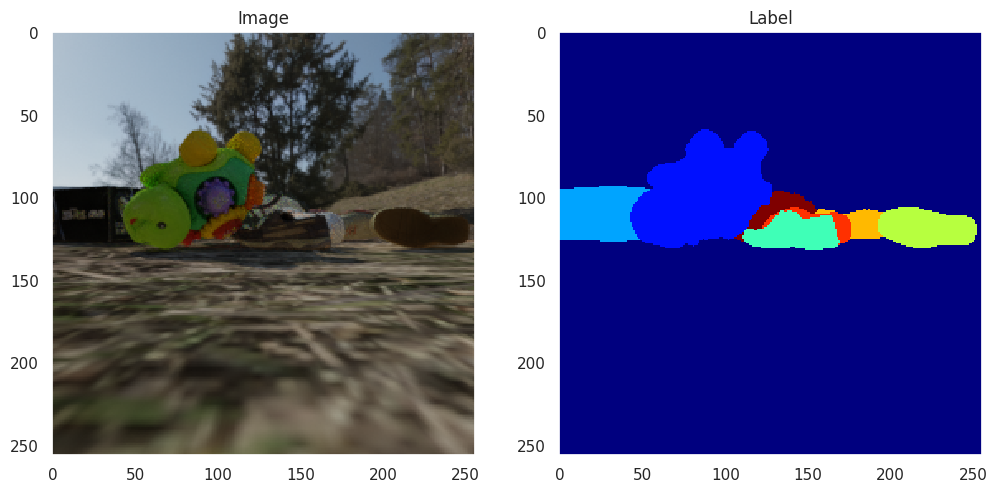

In [5]:
# Take one batch from the dataset
for X_train_batch, y_train_batch in dataset_train.skip(10).take(1):
    img_number = random.randint(0, X_train_batch.shape[0] - 1)

    img = X_train_batch[img_number]
    ground_truth = y_train_batch[img_number]

    # Plotting
    _, axs = plt.subplots(1, 2, figsize=(12, 8))

    plots ={
        "Image": img[..., 0],
        "Label": ground_truth
    }

    for ax, (name, plot) in zip(axs, plots.items()):
        ax.grid(False)
        ax.set_title(name)
        ax.imshow(plot, cmap="jet", interpolation="nearest")

plt.show()


In [6]:
# Define a simple mapping function
def preprocess(features, labels):
    # Convert labels to one-hot encoding
    y_cat = tf.one_hot(labels, depth=n_classes)
    y_cat = tf.squeeze(y_cat, axis=-2)

    return features, y_cat

# Apply the mapping function
dataset_train = dataset_train.map(preprocess)
dataset_val = dataset_val.map(preprocess)

In [7]:
print(dataset_train)

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 256, 256, 8), dtype=tf.float32, name=None))>


In [8]:
for features, labels in dataset_train.take(1):
    # If the dataset is batched, features and labels will have batch dimension as first dimension
    print("Batch size:", features.shape[0])
    print("Label shape:", labels.shape)
    print("Feature shape per sample:", features.shape[1:])
    print("Label shape per sample:", labels.shape[1:])


Batch size: 8
Label shape: (8, 256, 256, 8)
Feature shape per sample: (256, 256, 3, 1)
Label shape per sample: (256, 256, 8)


In [9]:
# load the test dataset
dataset_test = tf.data.Dataset.load('/content/drive/MyDrive/cv_data/test')
dataset_test = dataset_test.map(preprocess)
dataset_test = dataset_test.batch(batch_size)

print(dataset_test)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 256, 256, 8), dtype=tf.float32, name=None))>


In [10]:
for features, labels in dataset_test.take(1):
    # If the dataset is batched, features and labels will have batch dimension as first dimension
    print("Batch size:", features.shape[0])
    print("Label shape:", labels.shape)
    print("Feature shape per sample:", features.shape[1:])
    print("Label shape per sample:", labels.shape[1:])


Batch size: 8
Label shape: (8, 256, 256, 8)
Feature shape per sample: (256, 256, 3, 1)
Label shape per sample: (256, 256, 8)


# Evaluation

The code provides a comprehensive evaluation and visualization framework for semantic segmentation model performance. It includes functions for comparing model predictions to ground truth, computing Intersection over Union (IoU) for the background, Mean IoU, and Accuracy metrics on different datasets, and plotting metrics between main and ablation models. The code also loads pre-trained models and applies them to the test dataset, generating bar plots comparing performance metrics.

In [11]:
def show_img_pred(model_used, dataset=dataset_test, num_imgs=3, batch_skip=3):
    # Take one batch from the dataset
    for X_test_batch, y_test_batch in dataset.skip(batch_skip).take(num_imgs):
        # Randomly select an image from the batch
        # img_number = random.randint(0, X_test_batch.shape[0] - 1)
        img = X_test_batch[-1]
        # Normalize and reshape the image as required by the model
        img_norm = img[..., 0][..., None]
        img_input = np.expand_dims(img_norm, 0)

        ground_truth = y_test_batch[-1]
        ground_truth = np.argmax(ground_truth, axis=-1)

        # Make a prediction
        prediction = model_used.predict(img_input)
        predicted_img = np.argmax(prediction, axis=-1)[0, :, :]

        # Plotting
        _, axs = plt.subplots(1, 3, figsize=(12, 8))

        plots = {
            "Image": img[..., 0],
            "Ground Truth": ground_truth,
            "Prediction": predicted_img
        }
        for ax, (name, plot) in zip(axs, plots.items()):
            ax.set_title(f'{name}')
            ax.grid(False)
            ax.imshow(plot, cmap='jet', interpolation="nearest")
        plt.show()

    return ground_truth, predicted_img

In [12]:
def calculate_IoU(model_used, dataset=dataset_test, n_classes=8):
    IOU_background = IoU(
        num_classes=n_classes,
        sparse_y_true= False,
        sparse_y_pred=False,
        target_class_ids=[0] # for the background
    )


    for X_test, y_test in dataset:
        y_pred = model_used.predict(X_test, verbose=False)
        IOU_background.update_state(y_test, y_pred)

    # print(y_pred[0][0][0], y_test[0][0][0])
    # Calculate the Background IoU value
    return IOU_background.result().numpy()

def calculate_Mean_IoU(model_used, dataset=dataset_test, n_classes=8):
    Mean_IOU = MeanIoU(
        num_classes=n_classes,
        sparse_y_true= False,
        sparse_y_pred=False,
    )


    for X_test, y_test in dataset:
        y_pred = model_used.predict(X_test, verbose=False)
        Mean_IOU.update_state(y_test, y_pred)

    # print(y_pred[0][0][0], y_test[0][0][0])
    # Calculate the Mean IoU value
    return Mean_IOU.result().numpy()

def calculate_accuracy(model_used, dataset=dataset_test, n_classes=8):
    acc = CategoricalAccuracy()

    for X_test, y_test in dataset:
        y_pred = model_used.predict(X_test, verbose=False)
        acc.update_state(y_test, y_pred)

    # print(y_pred[0][0][0], y_test[0][0][0])
    # Calculate the Accuracy value
    return acc.result().numpy()


In [13]:
# Load previously saved model
model = load_model("/content/drive/MyDrive/saved_models/seg_model_aug_data.keras", compile=False)

In [14]:
model_ablation = load_model("/content/drive/MyDrive/saved_models/seg_model_ablation.keras", compile=False)

In [15]:
y_pred = model.predict(dataset_test)

18/18 [==============================] - 15s 141ms/step


In [16]:
y_pred.shape

(144, 256, 256, 8)

In [17]:
def plot_metric(metric_name, models, sets, values, ax):
    # Set up the bar positions
    bar_width = 0.35
    r1 = np.arange(len(sets))
    r2 = [x + bar_width for x in r1]

    # Plot the bars
    for i, model in enumerate(models):
        ax.bar(r1 if i % 2 == 0 else r2, values[i], width=bar_width, label=model)

    # Customize the plot
    ax.set_ylabel(f'{metric_name}')
    ax.set_title(f'Model vs Ablation {metric_name}')
    ax.set_xticks([r + bar_width / 2 for r in range(len(sets))], sets)
    ax.set_ylim(0, 1)
    ax.legend(models)

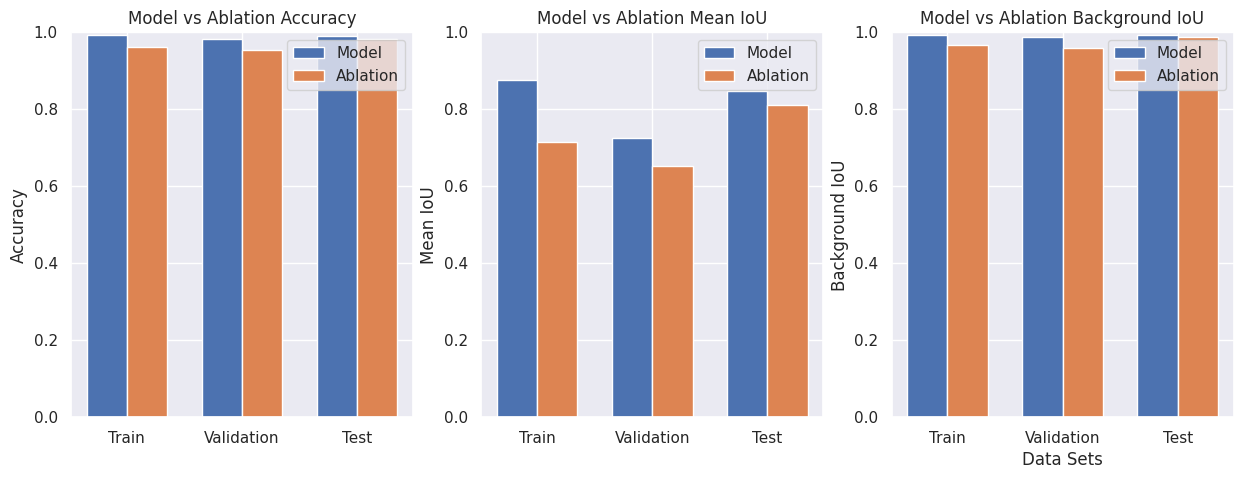

In [18]:
# Sample data (replace this with your actual data)
models = ['Model', 'Ablation']
sets = ['Train', 'Validation', 'Test']
metrics = [calculate_accuracy, calculate_Mean_IoU, calculate_IoU]
metrics_names = ["Accuracy", "Mean IoU", "Background IoU"]

_, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (ax, metric) in enumerate(zip(axs, metrics)):
    model_metrics = []
    ablation_metrics = []
    for dataset in [dataset_train, dataset_val, dataset_test]:
        model_metrics.append(metric(model, dataset=dataset))
        ablation_metrics.append(metric(model_ablation, dataset=dataset))

    plot_metric(metrics_names[i],
                models,
                sets,
                [model_metrics, ablation_metrics],
                ax=ax)

plt.xlabel('Data Sets')
plt.show()

# Image Prediction Comparison: Ground Truth vs. Model Predictions

The code compares ground truth and model predictions for image segmentation using the show_img_pred function. It extracts the ground truth and predicted images, displays unique values, and repeats for an alternative model (model_ablation). This analysis provides insights into segmentation results for both main and ablation models.

1/1 [==============================] - 2s 2s/step


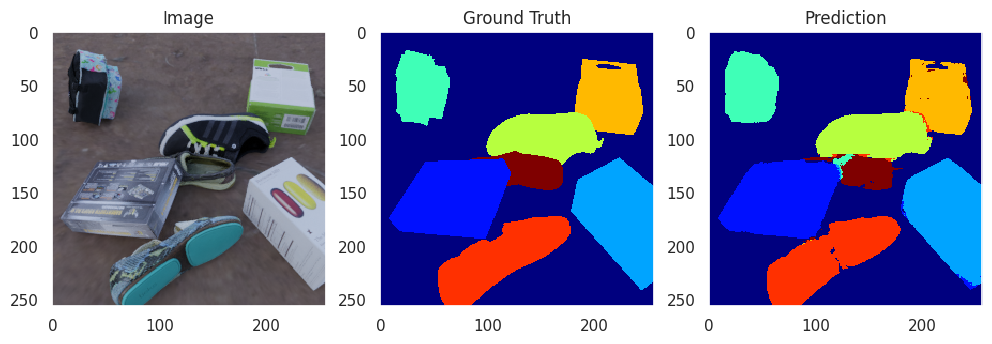

1/1 [==============================] - 0s 20ms/step


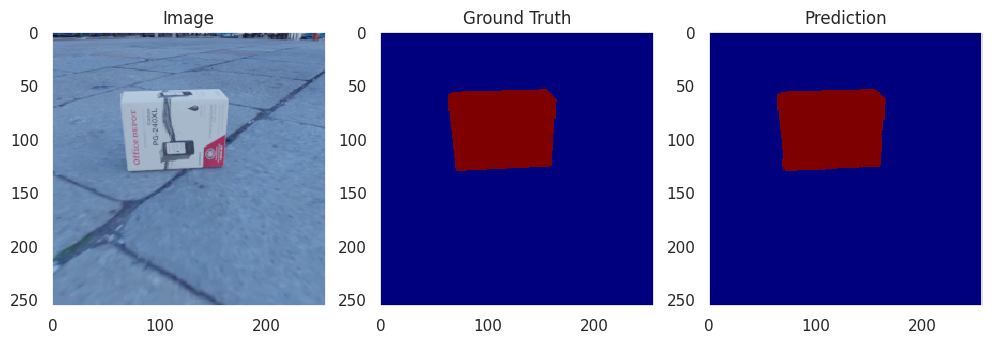

1/1 [==============================] - 0s 21ms/step


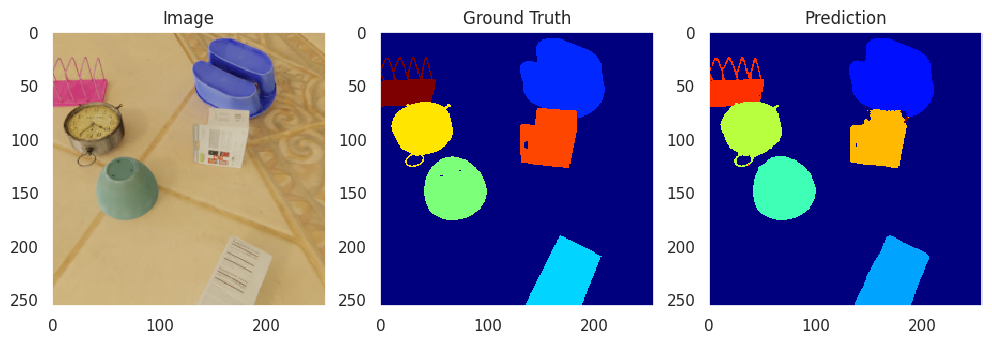

In [ ]:
ground_truth, predicted_img = show_img_pred(model, dataset=dataset_test)

In [ ]:
np.unique(ground_truth), np.unique(predicted_img)

(array([0, 1, 2, 3, 4, 5, 6]), array([0, 1, 2, 3, 4, 5, 6, 7]))

1/1 [==============================] - 0s 339ms/step


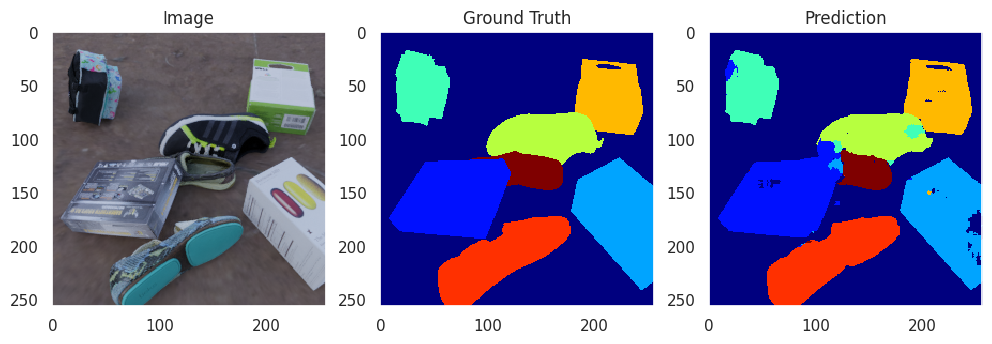

1/1 [==============================] - 0s 30ms/step


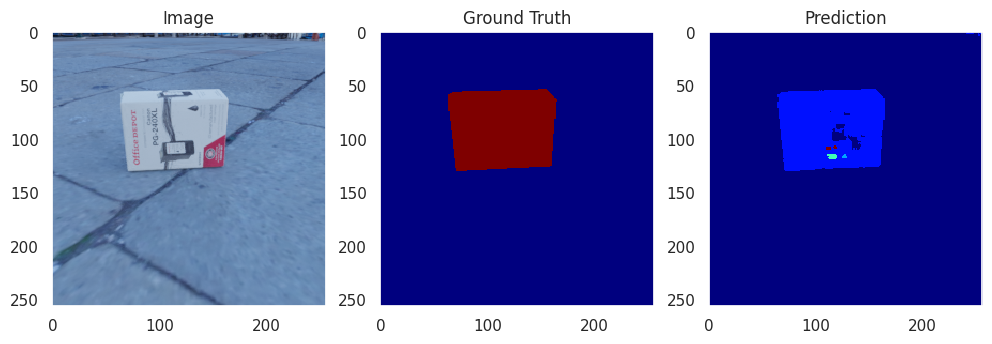

1/1 [==============================] - 0s 28ms/step


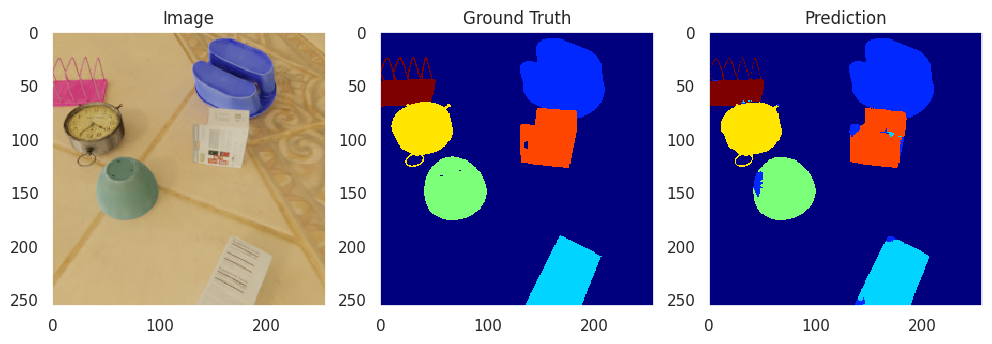

In [ ]:
ground_truth, predicted_img_ablation = show_img_pred(model_ablation, dataset=dataset_test)

In [ ]:
np.unique(ground_truth), np.unique(predicted_img_ablation)

(array([0, 1, 2, 3, 4, 5, 6]), array([0, 1, 2, 3, 4, 5, 6]))

As we can see from the results above, the ablation model's perfromance was nearly the same as the original model. The ablation model however misclassified some objects and didn't segment them as good as the original model.

As future work, deleting one block from the encoder and decoder and training the model again would useful and could perhaps achieve the same accuracy of the original model. Also, concatenating the output of the PoolMax layers and the input to a decoder block could help increase the accuracy and prevent the loss of information.